In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from experiments.models.utils import predict, calc_accuracy, train
from experiments.utils import load_data_wrapper, load_model

imported package "experiments"
imported package "models"
imported package "fourier"


### TODO:

1. ~~Load data (also custom)~~, specify classes
2. ~~Load/Train model (also custom)~~
3. ~~Choose attack (targeted or untargeted)~~
4. ~~Run attack on model (from all classes M samples)~~
5. ~~Pring statistics (l2, asr)~~
6. Plot tsne for examples
7. Plot confusion matrix

In [5]:
!export CUDA_VISIBLE_DEVICES=0

In [6]:
BATCH_SIZE = 128
NUM_WORKERS = 2
MODEL_IN_SZ = (224, 224) # image size of model input

#### Load Dataset (Bird Species)

_First go ahead and download the dataset from Kaggle_ [here](https://www.kaggle.com/datasets/gpiosenka/100-bird-species?resource=download).
_You should then extract it in the folder_ `./data/birds/` _and run_ `mv data/birds/valid/ data/birds/val/`.

`load_wrap(.)` takes numerous inputs, such as batch_size, root directory where images are stored or one dataset name ("cifar10" or "mnist"), image size and output size (for resizing images) as well as whether to load a validation set (validation=True).

In [7]:
trainset, trainloader, testset, testloader, validloader = load_data_wrapper(batch_size=BATCH_SIZE, root="./data/birds/", 
                                                                            dataset=None, augment=False, 
                                                                            input_size=(224, 224), output_size=MODEL_IN_SZ, 
                                                                            validation=True)

=> Loading dataset from path ./data/birds/
Loading dataset...
Resizing: (224, 224)
Augmentation: False
Filtering: None None


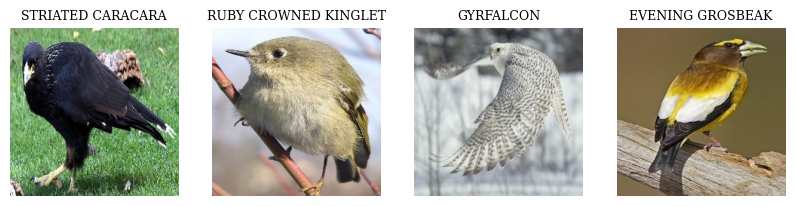

In [8]:
from torchvision.transforms import Compose, Normalize

def plot_images(images, titles, process):
    fig, ax = plt.subplots(1, len(images), figsize=(10,8))
    for i in range(4):
        ax[i].axis('off'), ax[i].set_title(titles[i], fontsize=9)
        ax[i].imshow(process(images[i]).permute(1,2,0))
    plt.show()

def random_sample(num_samples, dataset):
    indices = torch.randint(0, len(dataset), (num_samples,))
    examples = [dataset[i] for i in indices]
    images = [ex[0] for ex in examples]
    labels = [ex[1] for ex in examples]
    return images, labels


images, labels = random_sample(4, trainset)
denormalize = lambda x: Normalize(mean=[-0.5, -0.5, -0.5], std=[1., 1., 1.])(x)

labels_str = [trainset.classes[l] for l in labels]
plot_images(images, labels_str, denormalize)

#### Load model
We will use a ResNet50 model, as implemented with PyTorch (see here.).

`load_model(.)` takes as arguments the model architecture and the name with which we will save/load the model.

In [9]:
device = 'cuda'
model, model_name = load_model("resnet", layers=50, model_name="bird_species_resnet50", classes=len(trainset.classes))
model = model.to(device)
model.eval()

/home/deli_fo/foolproof/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deli_fo/foolproof/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Train model

We set some example hyper-parameters for training. Learning rate decay is used, specifically exponential decay ($lr=\gamma^\alpha * lr$) - see `experiments/models/utils.py`.

In [10]:
# train(model, trainloader, validloader, epochs=5, lr=0.001, lr_decay=0.0001, model_name=model_name)

In [11]:
# Load the pretrained model (you can also directly jump here without training a new model)
print(f"=> Using pretrained model checkpoint '{model_name}'.")
model.load_state_dict(torch.load(f"pretrained/{model_name}.pt", map_location=torch.device('cuda')))

=> Using pretrained model checkpoint 'bird_species_resnet50'.


<All keys matched successfully>

In [12]:
accuracy = calc_accuracy(model, testloader)
print("Test accuracy: %.2f"%(accuracy*100),"%")

Test accuracy: 90.82 %


#### Attacking the model - Untargeted C&W attack

We will run the **Carlini & Wagner** [\[1\]](https://arxiv.org/pdf/1608.04644.pdf) adversarial attack on our model.
This attack crafts an imperceptible to the human eye perturbation $\delta$ for a given image $x$ and model $f$, such that the model misclassifies the image $x+\delta$.

We will run an _untargeted_ attack, which only cares about misclassifying an image (e.g. to not classify an apple as an apple) _rather than_ classifying it as a _target class_ (e.g. to classify the apple as a banana).

We find $\delta$ by minimizing (via gradient descent) a loss function:

$$L = \|{\color{Green}\delta}\|_2 + c \cdot \min\{\max_y\{f_y(x+{\color{Green}\delta})\}-f_{true}(x+{\color{Green}\delta}), 0\}$$

where $f(x)$ is the vector of class scores, $f_y(x)$ is the score of x for class $y$ and $f_{true}(x)$ the score of the true class of $x$.

When minimizing $L$, we try to **balance minimizing the perturbation, and misclassifying the input $x$**.

Intuitively, as long as $x+\delta$ is not misclassified the second factor of $L$ is greater than zero, but if $x+\delta$ is misclassified, this term becomes 0 and the optimization focuses on finding the smallest possible $\delta$.

The value of $c$ is found via binary search in the range $[10^{-3}, 10^{10}]$ after a full optimization over $\color{Green}\delta$ is run.
In other words, we search for the smallest $c$ that gives a succesful attack.

_Note: Our loss function is slightly different to the one in [\[1\]](https://arxiv.org/pdf/1608.04644.pdf) since we use an untargeted attack paradigm instead of a targeted one as defined in the paper._

Let's illustrate what the magnitude of $\delta$ does by adding different amounts of noise to an image:

Noise with l2 norm = 0.5


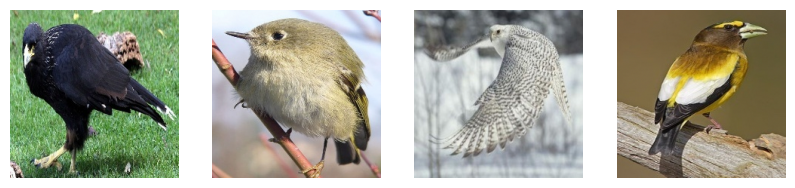

Noise with l2 norm = 10


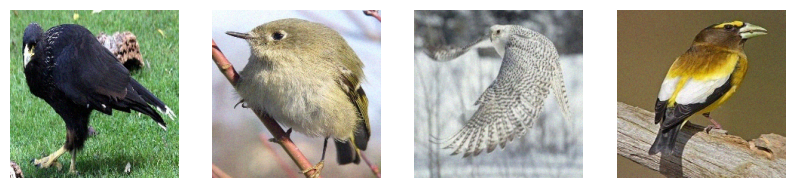

Noise with l2 norm = 50


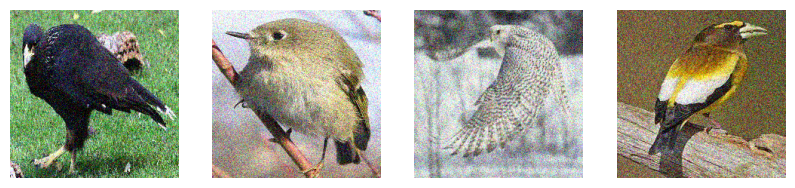

In [13]:
# Effect of adding noise of various l2 norms on an image

def add_noise(x, delta=0.1):
    noise = torch.randn(x.shape)
    noise_l2 = torch.norm(noise, 2)
    bounded_noise = noise * delta/noise_l2
    return (x + bounded_noise).clamp(0, 1)

delta = [0.5, 10, 50]
for d in delta:
    noisy_images = [add_noise(denormalize(x), d) for x in images]
    print(f"Noise with l2 norm = {d}")
    plot_images(noisy_images, [""]*len(images), lambda x: x)

In [14]:
# Here we import the modules for the C&W attack (there are two more attacks available in the package for you to try out!)
from experiments.attacks.cwattack import cw_attack_all
from experiments.attacks.utils import modified_frequencies, equal_samples

imported package "attacks"


In [15]:
from experiments.models.utils import check_correct_class

num_attack_samples = 10
    
def random_samples_true_prediction(num_samples, dataset, model):
    images, labels = [], []
    while (num_samples > 0):
        test_img, test_lab = random_sample(num_samples, dataset)
        flags = check_correct_class(torch.stack(test_img), torch.tensor(test_lab), model)
        images += [test_img[i] for i in range(len(test_img)) if flags[i]]
        labels += [test_lab[i] for i in range(len(test_lab)) if flags[i]]
        num_samples -= sum(flags)
    return images, labels
        
attack_images, labels = random_samples_true_prediction(num_attack_samples, testset, model)

# We need to construct a Dataloader with the image samples
attack_set = TensorDataset(torch.stack(attack_images), torch.tensor(labels))
attack_loader = DataLoader(attack_set, batch_size=BATCH_SIZE)

In [16]:
lr = 0.01
conf = 0.2
max_iterations = 20
bin_steps = 10

Let's explain the above parameters for a moment:

`lr` is the learning rate used during minimization. The optimizer we use is the standard Adam [\[2\]](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer from PyTorch.

`conf` is the _confidence_ with which we want to misclassify our image. It can also be set to 0, which gives the loss function we saw before. If `conf > 0` then the loss function becomes:

$$L = \|{\color{Green}\delta}\|_2 + c \cdot \min\{\max_y\{f_y(x+{\color{Green}\delta})\}-f_{true}(x+{\color{Green}\delta}), {\color{Teal}\text{conf}}\}$$

`max_iterations` is the number of optimization iterations we run our attack for.

`bin_steps` is the number of binary search steps we use to find the best $c$. 

Therefore, our attack runs for `max_iterations` x `bin_steps` total optimization steps.

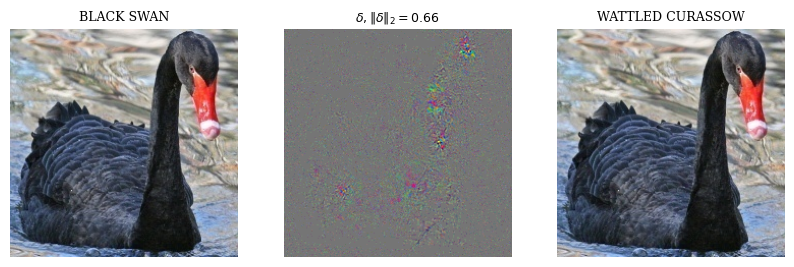

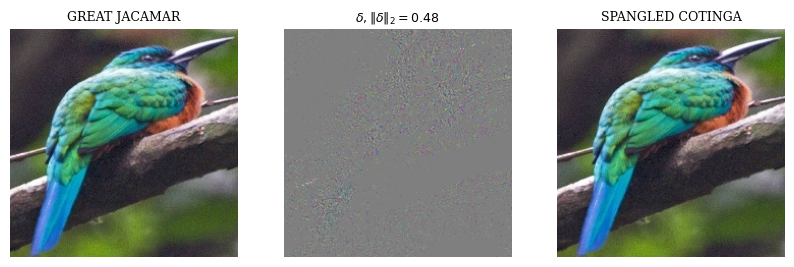

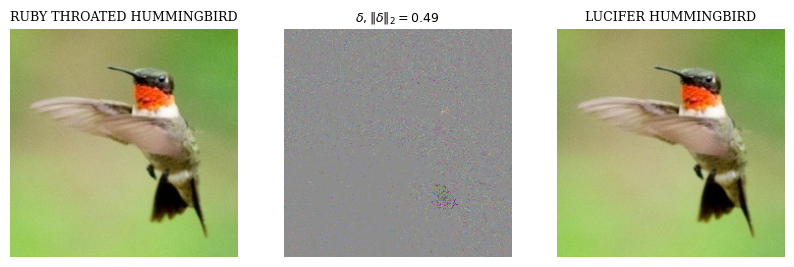

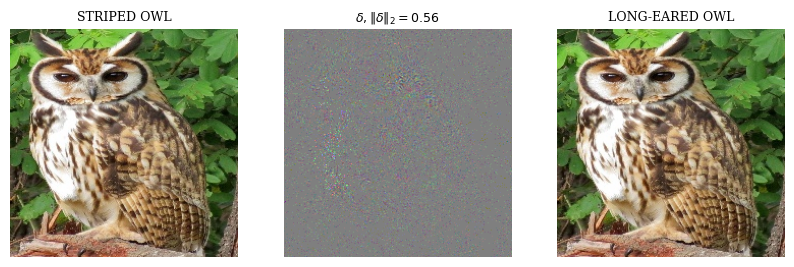

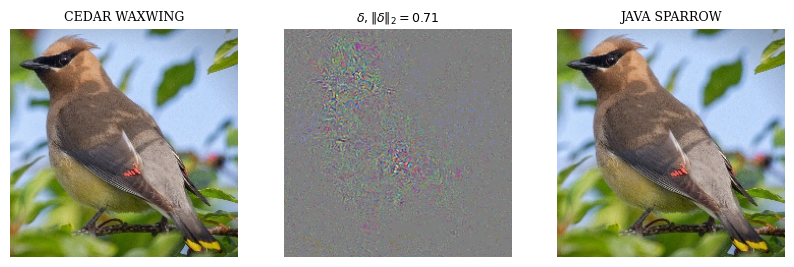

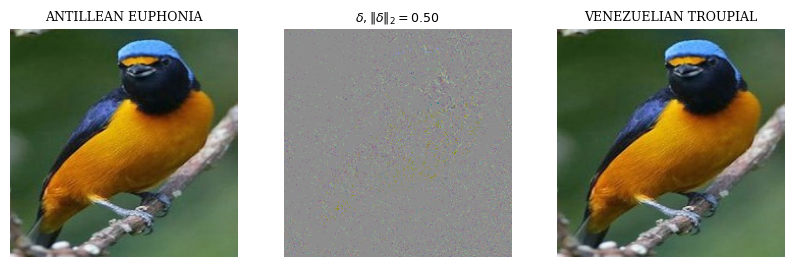

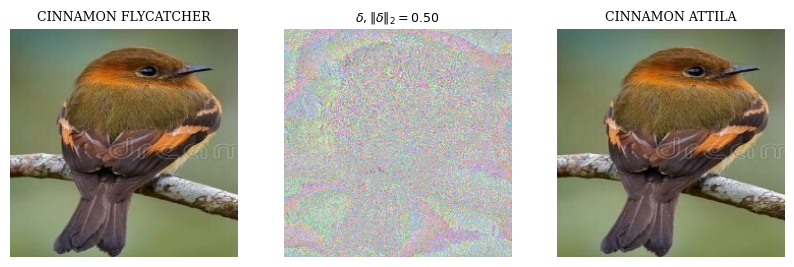

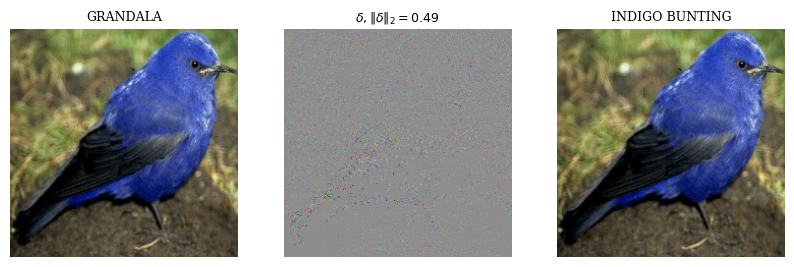

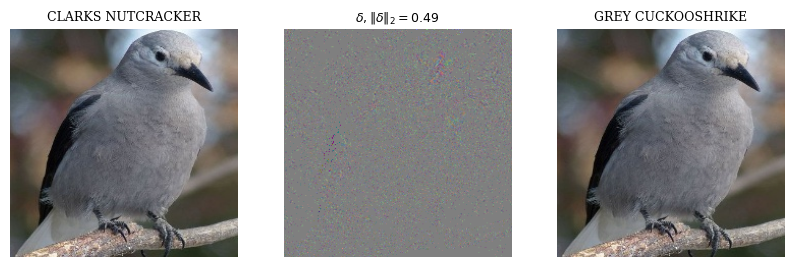

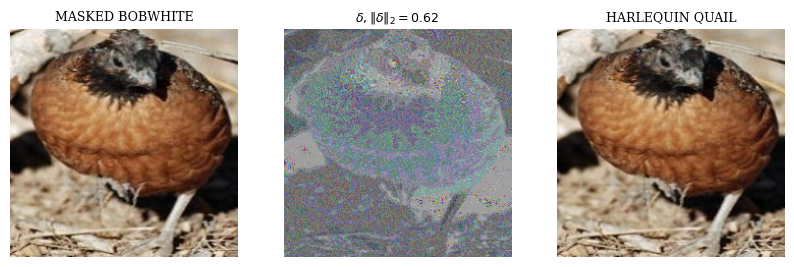


=> Attack took 10.271995 mins
Found attack for 10/10 samples.


In [17]:
results = cw_attack_all(model, model_name, attack_loader, False, attack_set, classes=trainset.classes, 
                        lr=lr, conf=conf, max_iterations=max_iterations, bin_steps=bin_steps)
results = results.detach().cpu()

We got a 10/10 success rate on our images! Not sure if this is a success or a failure... =\

We need a tool to visualize the difference between the perturbed, adversarial images and the original ones.

For that we will use **t-SNE** [\[2\]](https://jmlr.org/papers/v9/vandermaaten08a.html) to project some data samples to a two-dimensional space.

In [18]:
# Let's evaluate our attack
from sklearn.manifold import TSNE

true_labels = [int(x[1]) for x in attack_set]
wrong_labels = []
for img in results:
    scores = model(img.unsqueeze(0).cuda())[0].cpu()
    wrong_labels.append(int(torch.argmax(scores)))

true_labels, wrong_labels

([82, 254, 430, 466, 136, 33, 148, 248, 151, 343],
 [502, 456, 333, 331, 313, 491, 147, 302, 266, 277])

In [19]:
def get_class_example_scores(model, target_class, n_samples, dataloader):
    softmax = torch.nn.Softmax(dim=1)
    scores = []
    for b_img, b_labels in dataloader:
        b_scores = model(b_img.cuda()).detach().cpu()
        for sc, label in zip(b_scores, b_labels):
            probabilities = softmax(sc.unsqueeze(0))[0]
            pred = int(torch.argmax(probabilities))
            if label == target_class and pred == label and probabilities[pred] > 0.6:
                scores.append(sc)
                n_samples -= 1
            if n_samples == 0:
                return scores
    print(f"Not emough samples belonging to class {target_class} were found, found {len(scores)} results.")
    return scores

idx = 1
num_examples = 50
true_label, wrong_label = true_labels[idx], wrong_labels[idx]
true_label_scores = get_class_example_scores(model, true_label, 
                                              num_examples, trainloader)
wrong_label_scores = get_class_example_scores(model, wrong_label, 
                                               num_examples, trainloader)

assert (len(true_label_scores), len(wrong_label_scores)) == (num_examples, num_examples)

orig_img_scores = model(attack_set[idx][0].cuda().unsqueeze(0))[0].detach().cpu()
perturbed_img_scores = model(results[idx].cuda().unsqueeze(0))[0].detach().cpu()

In [20]:
n_com = 2

tsne = TSNE(n_components=n_com, perplexity=10.0, early_exaggeration=12.0,
            learning_rate='auto', n_iter=1000, )
all_scores = [orig_img_scores]+true_label_scores
all_scores += [perturbed_img_scores] + wrong_label_scores
all_scores = torch.stack(all_scores)
scores_tsne = tsne.fit_transform(all_scores)

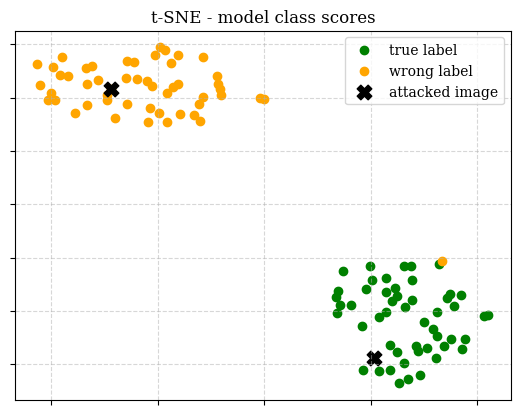

In [36]:
fig, ax = plt.subplots(1, 1)
ax.grid(alpha=0.5, linestyle="--")

# x = scores_tsne[:20]
ax.scatter(scores_tsne[:num_examples,0],scores_tsne[:num_examples,1], c="green", label=f"true label")
ax.scatter(scores_tsne[num_examples,0],scores_tsne[num_examples,1], c="black", marker='X', s=110)

ax.scatter(scores_tsne[num_examples+1:,0],scores_tsne[num_examples+1:,1], 
           c="orange", label=f"wrong label")
ax.scatter(scores_tsne[-1,0],scores_tsne[-1,1], c="black", marker='X', s=110, label="attacked image")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("t-SNE - model class scores")
ax.legend()
plt.show()

What we did above was following:
1. we picked one adversarial example, with its true and wrong class, wrong meaning the class it is classified as after adding the perturbation $\delta$.
2. we sampled images from the training set, for both the true and wrong class - specifically, ones that are correctly classified with confidence greater than 60%.
3. we extracted the classification scores for these samples and then projected them to a 2-dimensional space using t-SNE.

It is now visible how far apart the original image is, compared to the adversarial one, in this 2-dimensional latent space. Both are inside their respective class clusters (green and orange cluster).

Feel free to play around with this notebook. Try your own dataset, further fine-tune a vision model, test out different attacks or dive deeper into the C&W attack to get better results.

Have fun!